# Template Molecule-based Masking

This uses the "Cube Reprojection and Signal Masking Tutorial" (public version available [here](https://gist.github.com/abulatek/cc1cd9e62a04c7b5487f3a45d9633823)) written by Adam Ginsburg, Eric Koch, Tom Robitaille, and Erik Rosolowsky and adapted by Alyssa Bulatek. It uses an H2CS cube to create a signal mask for a rung of a CH3CN ladder (which has a more complicated velocity structure), putting both cubes on the same velocity grid in the process.

## Navigation

1. [Access the data](#1.-Access-the-data)
2. [Find lines in cubes](#2.-Find-lines-in-cubes)
3. [Convert cube spectral axes from frequency to velocity](#3.-Convert-cube-spectral-axes-from-frequency-to-velocity)
4. [Spectral Interpolation](#4.-Spectral-Interpolation)
5. [Spatial Smoothing](#5.-Spatial-Smoothing)
6. [Reprojection](#6.-Reprojection)
7. [Signal Masking](#7.-Signal-Masking)
8. [Moment Maps](#8.-Moment-Maps)
9. [Masking Outliers](#9.-Masking-Outliers)
10. [Export Masked Cubes](#10.-Export-Masked-Cubes)

In [1]:
import pylab as pl
# pl.style.use('dark_background')

# plt.rc('text', usetex = True) # Use LaTeX font in plots
# plt.rc('font', family = 'serif')
# plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'
# plt.rcParams.update({'font.size': 14})
display_dpi = 150

## 1. Access the data

In [2]:
# %matplotlib inline
from spectral_cube import SpectralCube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

First, we'll get the template molecule cube (H2CS).

In [3]:
# Get H2CS (template molecule) cube
freq_spw = '135_spw47'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
h2cscube = SpectralCube.read(fn, format='casa_image')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Then, we'll get the target molecule cube (CH3CN).

In [4]:
# Get methyl cyanide (target molecule) cube
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


## 2. Find lines in cubes
We'll use Splatalogue to list the lines within the frequency ranges of each cube to confirm that we're covering the lines we want to cover.

In [5]:
from astroquery.splatalogue import Splatalogue
h2cscube.find_lines(chemical_name='H2CS', line_lists=['JPL'], 
                    show_upper_degeneracy=True).show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
0,H2CS,Thioformaldehyde,--,--,135.297811,0.00025,"4(1,4)-3(1,3)",-3.2444,30.5155,11.222,-4.48704,0.64,15.937,22.92966,20.45005,29.42289,27.0,JPL


In [6]:
ch3cntbl = ch3cncube.find_lines(chemical_name='CH3CN', line_lists=['JPL'], 
                                show_upper_degeneracy=True, show_qn_code=True)
ch3cntbl = ch3cntbl[ch3cntbl['Quantum Number Code'] == 202]
ch3cntbl = ch3cntbl[::-1]
ch3cn_freqs = ch3cntbl['Freq-GHz(rest frame,redshifted)']
ch3cntbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist
0,CH3CNv=0,Methyl Cyanide,147.1745883,2e-07,--,--,8(0)-7(0),-2.6575,169.60673,11.02642,-3.7326,--,17.1828,24.72238,22.09202,31.78569,34.0,202,JPL
1,CH3CNv=0,Methyl Cyanide,147.1717519,2e-07,--,--,8(1)-7(1),-2.6748,166.91824,10.85164,-3.73957,--,22.1491,31.86782,27.05822,38.931,34.0,202,JPL
2,CH3CNv=0,Methyl Cyanide,147.1632441,2e-07,--,--,8(2)-7(2),-2.727,158.99516,10.33654,-3.76076,--,37.047,53.30272,41.95584,60.36548,34.0,202,JPL
3,CH3CNv=0,Methyl Cyanide,147.1490683,1e-07,--,--,8(3)-7(3),-2.5156,291.45821,18.94819,-3.79873,--,61.8731,89.02217,66.78146,96.08426,68.0,202,JPL
4,CH3CNv=0,Methyl Cyanide,147.1292302,1e-07,--,--,8(4)-7(4),-2.9482,127.19471,8.26914,-3.85798,--,96.6217,139.01798,101.5294,146.07911,34.0,202,JPL
5,CH3CNv=0,Methyl Cyanide,147.103738,1e-07,--,--,8(5)-7(5),-3.1316,103.33459,6.71796,-3.94843,--,141.2849,203.27878,146.19175,210.33869,34.0,202,JPL
6,CH3CNv=0,Methyl Cyanide,147.0726021,1e-07,--,--,8(6)-7(6),-3.0883,148.38336,9.64665,-4.09259,--,195.8526,281.79004,200.75841,288.84846,68.0,202,JPL
7,CH3CNv=0,Methyl Cyanide,147.0358351,1e-07,--,--,8(7)-7(7),-3.7949,39.74307,2.58376,-4.36401,--,260.3123,374.53377,265.21689,381.59042,34.0,202,JPL


## 3. Convert cube spectral axes from frequency to velocity
Here, we convert the spectral axis of each cube from frequency to velocity, using the rest frequency of each line (which we can see in the step above) to do the conversion.

In [7]:
h2cscube = h2cscube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                       rest_value=135.297811*u.GHz).spectral_slab(-10*u.km/u.s, 
                                                                                  80*u.km/u.s)
print(h2cscube)
h2cssubcube = h2cscube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)

DaskVaryingResolutionSpectralCube with shape=(85, 512, 512) and unit=Jy / beam and chunk size (68, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     85  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      80.460 km / s


## **LOOK HERE ALYSSA!!! THIS CELL BELOW IS WHERE I AM CHANGING THE INDEX FOR EACH RUNG**

In [8]:
ch3cncube = ch3cncube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                         rest_value=ch3cn_freqs[0]*u.GHz).spectral_slab(-10*u.km/u.s, 
                                                                                        80*u.km/u.s)
print(ch3cncube)
ch3cnsubcube = ch3cncube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)

DaskVaryingResolutionSpectralCube with shape=(91, 512, 512) and unit=Jy / beam and chunk size (71, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      79.868 km / s


### *REMEMBER TO DO THE SAME FOR THE HIGH-VELOCITY COMPONENTS!*

### 3.1. Do some quicklooks of the peak intensity to see what we expect to see

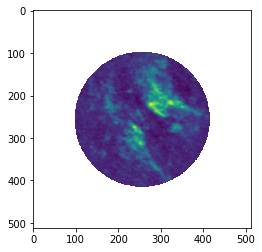

In [9]:
h2cssubcube.max(axis=0).quicklook()
# This first quicklook has to be re-run, as it doesn't run the first time (not sure why)

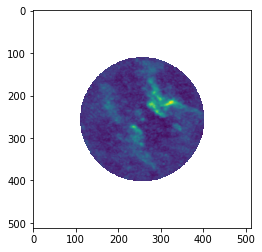

In [10]:
ch3cnsubcube.max(axis=0).quicklook()

## 4. Spectral Interpolation
First of all, we need to convert these cubes from `VaryingResolutionSpectralCubes` to `SpectralCubes`. First, we'll compare the beam sizes of the cubes.

In [11]:
h2cssubcube.beams, ch3cnsubcube.beams

(<Beams [5.54782914e-11, 5.54786541e-11, 5.54790393e-11, 5.54794101e-11,
         5.54797749e-11, 5.54801437e-11, 5.54804993e-11, 5.54808641e-11,
         5.54812227e-11, 5.54815853e-11, 5.54819695e-11, 5.54823343e-11,
         5.54827113e-11, 5.54830658e-11, 5.54834461e-11, 5.54838098e-11,
         5.54841798e-11, 5.54845547e-11, 5.54849266e-11, 5.54852862e-11,
         5.54856530e-11, 5.54860146e-11, 5.54863998e-11, 5.54867451e-11,
         5.54871243e-11, 5.54874675e-11, 5.54878567e-11, 5.54882113e-11,
         5.54885853e-11, 5.54889633e-11, 5.54893137e-11, 5.54896959e-11,
         5.54900586e-11, 5.54904131e-11, 5.54907831e-11, 5.54911520e-11,
         5.54915250e-11, 5.54918918e-11] sr>,
 <Beams [4.77419483e-11, 4.77416592e-11, 4.77413732e-11, 4.77410841e-11,
         4.77407998e-11, 4.77405117e-11, 4.77402069e-11, 4.77399284e-11,
         4.77396318e-11, 4.77393506e-11, 4.77390635e-11, 4.77387792e-11,
         4.77384960e-11, 4.77381966e-11, 4.77379229e-11, 4.77376342e-11,
     

Now, we'll smooth each cube to the common beam for that cube.

In [12]:
h2cssubcube_common_beam = h2cssubcube.beams.common_beam()
h2cssubcube_b = h2cssubcube.convolve_to(h2cssubcube_common_beam)
ch3cnsubcube_common_beam = ch3cnsubcube.beams.common_beam()
ch3cnsubcube_b = ch3cnsubcube.convolve_to(ch3cnsubcube_common_beam)
h2cssubcube_b.beam, ch3cnsubcube_b.beam

(Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg,
 Beam: BMAJ=1.510909080505371 arcsec BMIN=1.1864451169967651 arcsec BPA=-81.83074951171875 deg)

Now, we must match the spectral resolution of the template and target cubes. To begin, we'll convert the spectral axis units back to km/s from m/s. The `b` stands for beam (since we're doing some beam smoothing).

In [13]:
# This might not be the neatest way to do this
h2cssubcube_b = h2cssubcube_b.with_spectral_unit(u.km/u.s)
ch3cnsubcube_b = ch3cnsubcube_b.with_spectral_unit(u.km/u.s)
h2cssubcube_b, ch3cnsubcube_b

(DaskSpectralCube with shape=(38, 512, 512) and unit=Jy / beam and chunk size (38, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     38  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(41, 512, 512) and unit=Jy / beam and chunk size (41, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     41  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      30.136 km / s)

We'll start by printing the spectral resolutions for each cube to compare them.

In [14]:
import numpy as np
velocity_res_1 = np.diff(h2cssubcube_b.spectral_axis)[0]
velocity_res_2 = np.diff(ch3cnsubcube_b.spectral_axis)[0]
np.abs(velocity_res_1), np.abs(velocity_res_2)

(<Quantity 1.08196348 km / s>, <Quantity 0.99465058 km / s>)

Since the channel width of the H2CS (template) cube is larger, we'll smooth the resolution of the CH3CN (target) cube to the broader resolution. We will do this by smoothing with a Gaussian with an appropriate FWHM.

In [15]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 0.42581121 km / s>

In [16]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# We want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

Now, we will cut the cubes so they only cover a common velocity range (essentially cutting the larger cube down to the smaller cube, but this is a general way to do that in case they overlap incompletely). Since we're working with subcubes, the difference isn't too great (and we expect the boundaries after the cut to be not exactly the same between cubes, since the velocity grid is still different). The `c` stands for "cutout."

In [17]:
vel_lo = np.max([h2cssubcube_b.spectral_axis.min().value, 
                 ch3cnsubcube_b.spectral_axis.min().value])*u.km/u.s
vel_hi = np.min([h2cssubcube_b.spectral_axis.max().value, 
                 ch3cnsubcube_b.spectral_axis.max().value])*u.km/u.s

h2cssubcube_bc = h2cssubcube_b.spectral_slab(vel_lo, vel_hi)
ch3cnsubcube_bc = ch3cnsubcube_b.spectral_slab(vel_lo, vel_hi)
h2cssubcube_bc, ch3cnsubcube_bc

(DaskSpectralCube with shape=(37, 512, 512) and unit=Jy / beam and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(40, 512, 512) and unit=Jy / beam and chunk size (40, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     40  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      29.141 km / s)

We then smooth with the kernel.  Note that this is doing 512*512 = 262144 smoothing operations on a length-41 spectrum: it will take a little time. The `spec` stands for "spectral interpolation."

In [18]:
ch3cnsubcube_bc_spec = ch3cnsubcube_bc.spectral_smooth(spectral_smoothing_kernel)

Now that we've done spectral smoothing, we can resample the spectrum.

In [19]:
ch3cnsubcube_bc_spec_resample = ch3cnsubcube_bc_spec.spectral_interpolate(h2cssubcube_bc.spectral_axis)
ch3cnsubcube_bc_spec_resample

DaskSpectralCube with shape=(37, 512, 512) and unit=Jy / beam and chunk size (37, 1, 1):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

## 5. Spatial Smoothing
Now that we've done spectral smoothing, we have to spatially smooth, because we'll resample the data spatially too. Finally, we'll convolve both cubes to a common beam that matches the larger beam size.

In [20]:
h2cssubcube_bc.beam, ch3cnsubcube_bc_spec_resample.beam

(Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg,
 Beam: BMAJ=1.510909080505371 arcsec BMIN=1.1864451169967651 arcsec BPA=-81.83074951171875 deg)

The H2CS (template) cube has the larger beam, so we'll smooth the CH3CN (target) cube to its resolution. First, calculate the common beam:

In [21]:
import radio_beam
common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[h2cssubcube_bc.beam, 
                                                                          ch3cnsubcube_bc_spec_resample.beam]))
common_beam

Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg

Now, we'll convolve the CH3CN beam to match the larger H2CS beam. We'll convert to Kelvin to ensure the units are preserved. The `spat` stands for "spatial smoothing."

In [22]:
ch3cnsubcube_bc_spec_resample_spat = ch3cnsubcube_bc_spec_resample.to(u.K).convolve_to(common_beam)
ch3cnsubcube_bc_spec_resample_spat
# This takes a long time, and has a new warning:
# WARNING: nan_treatment='interpolate', however, NaN values detected post convolution.
# A contiguous region of NaN values, larger than the kernel size, are present in the input array. 
# Increase the kernel size to avoid this. [astropy.convolution.convolve]

DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

## 6. Reprojection
Now, we can reproject one cube onto the other.

In [23]:
import astropy
print(astropy.__version__)
import reproject
print(reproject.__version__)
# Need development version of astropy
# 4.3.dev1788+ga3263b6 works for me

4.3.dev1788+ga3263b6
0.8.dev31+g9f8ec7b


In [24]:
ch3cnsubcube_bc_reproj = ch3cnsubcube_bc_spec_resample_spat.reproject(h2cssubcube_bc.header)
ch3cnsubcube_bc_reproj
# This is currently taking a longgggg time to run, which is a sign that something went wrong?

DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

These two cubes are now on an identical grid, and can be directly compared:

In [25]:
ch3cnsubcube_bc_reproj, h2cssubcube_bc

(DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(37, 512, 512) and unit=Jy / beam and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam.

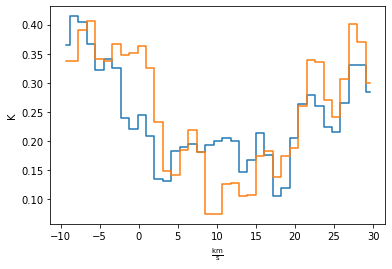

In [26]:
h2cssubcube_bc[:,256,256].to(u.K).with_spectral_unit(u.km/u.s).quicklook()
ch3cnsubcube_bc_reproj[:,256,256].quicklook()

### Do a quick continuum subtraction
Since we're focusing on spectral line emission, we'll perform continuum subtraction on each cube, and rename the cubes while we're at it (the `f` stands for "final").

In [27]:
med1 = h2cssubcube_bc.median(axis=0)  
h2cssubcube_f = h2cssubcube_bc - med1
med2 = ch3cnsubcube_bc_reproj.median(axis=0)  
ch3cnsubcube_f_reproj = ch3cnsubcube_bc_reproj - med2

## 7. Signal Masking
We'll now use the template molecule, H2CS, to mask the target molecule, CH3CN. This is useful because CH3CN has a complicated multi-component velocity structure (and thus the rungs of the ladder overlap). H2CS a similar morphology on the sky, so we can use that to grab the matching component of the CH3CN velocity structure.

First, we'll estimate the noise throughout the template H2CS cube by using a signal-resistant measurement of the standard deviation (called the median absolute deviation [MAD] standard deviation). We'll sigma-clip the cube first at 3 sigma and plot the spectrum to look for where the noise is least affected by signal.

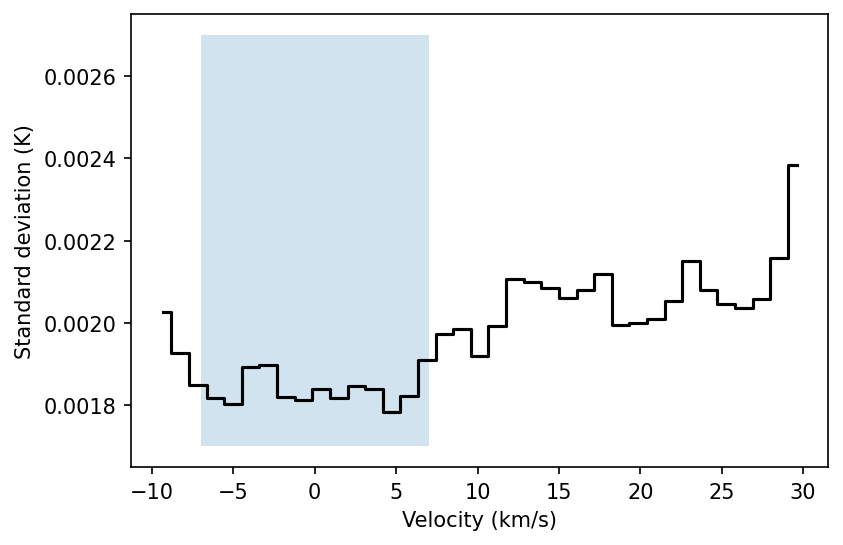

In [28]:
import matplotlib.pyplot as plt

# For rectangle:
import matplotlib.patches as mpatches
fig = plt.figure(dpi = display_dpi)
ax = fig.add_subplot(111)

# Make signal mask out of template molecule cube, in noise-free area (should be flat)
h2cs_sclip = h2cssubcube_f.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = h2cs_sclip.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid', c='k')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Standard deviation (K)')

flat_noise = mpatches.Rectangle((-7, 0.0017), 14, 0.001, alpha = 0.2, facecolor = "tab:blue")
plt.gca().add_patch(flat_noise)

plt.savefig("figures/flat_noise.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

The noise estimate here varies slightly as a function of velocity (though the extent of the *y*-axis is not too great), but we can try to use the spectrum between about -7 and 7 km/s (which seems marginally flatter) to estimate the noise map.

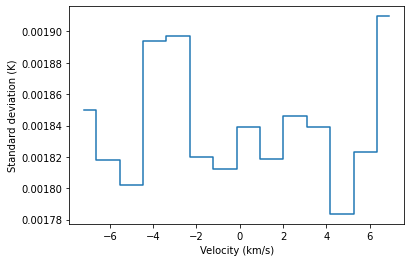

In [29]:
h2cs_sclip_cut = h2cs_sclip.spectral_slab(-7*u.km/u.s, 7*u.km/u.s)
mad_std_spectrum_sclip_cut = h2cs_sclip_cut.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip_cut.spectral_axis.value, mad_std_spectrum_sclip_cut.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r'Standard deviation (K)')
mad_std_map_sclip = h2cs_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension

We will take a quick look at the noise map to make sure it looks okay.

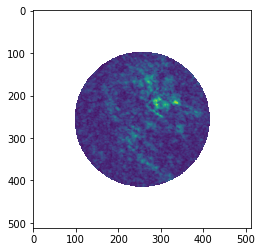

In [30]:
mad_std_map_sclip.quicklook()

Now, we'll create a "plain mask" where we mask the template cube and only keep pixels that are at or above 3 sigma (where sigma is given on a pixel-by-pixel basis by the noise map we just created).

In [31]:
plain_mask = h2cssubcube_f >= 3 * mad_std_map_sclip # Get plain 3sigma mask
plain_masked_slab = h2cssubcube_f.with_mask(plain_mask) # Mask the template molecule cube

Then, we'll apply that mask to the template molecule cube and create a more sophisticated "signal mask" from that cube, which takes into account the fact that connected regions of signal are more likely to be real than an individual high-sigma pixel.

In [32]:
import scipy.ndimage as nd
# Make a low and high mask
low_snr_mask = (plain_masked_slab > 3 * mad_std_map_sclip).include()
high_snr_mask = (plain_masked_slab > 10 * mad_std_map_sclip).include()
low_snr_mask = low_snr_mask.compute() # Don't need this for this tutorial
high_snr_mask = high_snr_mask.compute() # Don't need this for this tutorial
# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)
low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
print(f"Initial number of regions found: {num_labels}")
# From the labels, count the number of pixels within each label.
num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels
# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels
# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask
low_min_pixels = 40
high_min_pixels = 10
for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                      num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue
    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)
print(f"Final number of regions found: {num_labels}")
signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)

Initial number of regions found: 1330
Final number of regions found: 5


Finally, we'll apply the signal mask we just created using the template molecule cube (which has a mask at each velocity step) to the target molecule cube.

In [33]:
masked_cube = ch3cnsubcube_f_reproj.with_mask(signal_mask)
# We can write the masked cube to a file and look at it in DS9, but this is optional:
# masked_cube.write('masked_target_cube.fits', overwrite=True)
# masked_cube = SpectralCube.read('masked_target_cube.fits')

Let's visualize the mask.

In [34]:
pl.rcParams['figure.facecolor'] = 'w'

In [35]:
from astropy.visualization import simple_norm

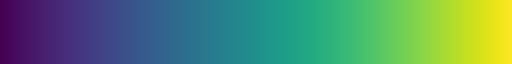

In [36]:
pl.matplotlib.cm.viridis.copy()

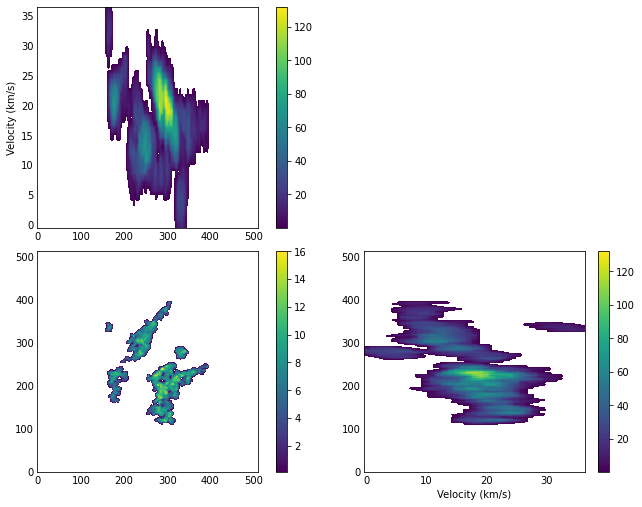

In [37]:
mask = signal_mask.sum(axis=0)
collapse1 = signal_mask.sum(axis = 1)
collapse2 = signal_mask.sum(axis = 2)

vmax = np.max([mask.max(), collapse1.max(), collapse2.max()])
norm = simple_norm(mask, stretch='linear', max_cut=vmax, min_cut=0.1)

cm = pl.matplotlib.cm.viridis.copy()
cm.set_under('w')

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize = (9, 10), constrained_layout=True)

ax1 = plt.subplot(323, aspect = 1)
im1 = ax1.imshow(mask, origin='lower', cmap=cm, vmin=0.1) # cmap='inferno', aspect='auto'
ax1.tick_params(direction='in', color='#FFFFFF')
pl.colorbar(mappable=im1)

ax2 = plt.subplot(321, sharex = ax1, adjustable='box')
im2 = ax2.imshow(collapse1, origin='lower', norm=norm, cmap=cm) # cmap='gray'
ax2.set_ylabel('Velocity (km/s)')
ax2.tick_params(direction='in', color='#FFFFFF')
ax2.set_aspect(collapse1.shape[1]/collapse1.shape[0])
pl.colorbar(mappable=im2)

ax3 = plt.subplot(324, sharey = ax1)
im3 = ax3.imshow(collapse2.T, origin='lower', norm=norm, cmap=cm) # cmap='gray', aspect='auto'
ax3.set_xlabel('Velocity (km/s)')
ax3.tick_params(direction='in', color='#FFFFFF')
ax3.set_aspect(collapse2.shape[0]/collapse2.shape[1])

#pl.colorbar(cax=[0.95,0.5,0.1,0.8], mappable=im3)
pl.colorbar(mappable=im3)

# fig, axs = plt.subplots(2, 2, sharex="col", sharey="row",
#                         gridspec_kw=dict(height_ratios=[1, 3],
#                                          width_ratios=[3, 1]))
# axs[0, 1].set_visible(False)
# axs[0, 0].set_box_aspect(1/3)
# axs[1, 0].set_box_aspect(1)
# axs[1, 1].set_box_aspect(3/1)

# x, y = np.random.randn(2, 400) * [[.5], [180]]
# axs[1, 0].imshow(mask) # origin='lower', adjustable='box'
# axs[0, 0].imshow(collapse1)
# axs[1, 1].imshow(collapse2.T)

# plt.show()

## 8. Moment Maps
First, we'll create some initial moment maps of the target molecule using the cube we just masked.

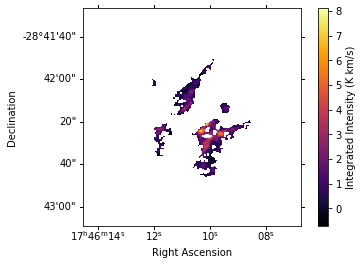

In [38]:
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

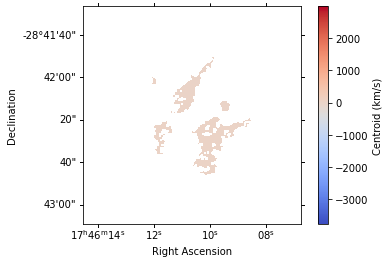

In [39]:
masked_moment1 = masked_cube.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The color bar on the moment 1 map is skewed due to the presence of at least one outlier pixel with a large negative velocity.

## 9. Masking Outliers
At the moment, to get a better idea of the velocity structure of the target molecule, we can mask the outliers by masking pixels with a moment 0 value less than some threshold, which can cause moment 1 values to blow up since the moment 0 value appears in the denominator of the moment 1 value.

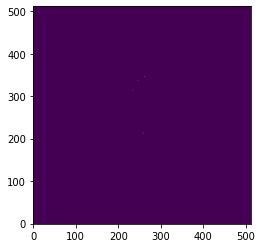

In [40]:
from pylab import imshow
v_thresh = 1000
masked_moment1 = masked_cube.moment1()
masked_moment1_outliers = (masked_moment1 > v_thresh*u.km/u.s)|(masked_moment1 < -v_thresh*u.km/u.s)
imshow(masked_moment1_outliers, origin='lower') 
# Clumps of outliers might mean they're real, just outside of vel range

We can look at a spectrum of an outlier pixel individually and check neighboring spectra.

-3757.866491169906 km / s


Text(0, 0.5, 'Intensity (K)')

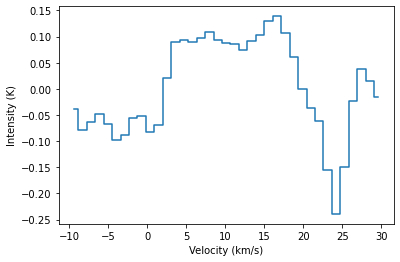

In [41]:
max_vel_coord = np.unravel_index(np.nanargmin(masked_moment1), masked_moment1.shape)
spectrum = masked_cube[:, max_vel_coord[0], max_vel_coord[1]]
print(masked_moment1[max_vel_coord[0], max_vel_coord[1]])
plt.plot(spectrum.spectral_axis, spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')

Now, we'll remove outliers by removing all pixels with moment 0 values less than a threshold value.

In [42]:
mom0 = masked_cube.moment0()
mom0_mask = mom0 > 0.3*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
print(f"Found {mom0_mask.sum()} good pixels")
masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)

Found 11639 good pixels


We'll make more final moment maps now.

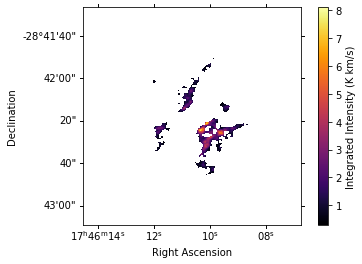

In [43]:
masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

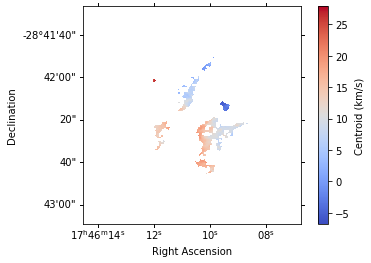

In [44]:
masked_moment1 = masked_cube_no_outliers.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The velocity structure is more visible here with the outliers removed.

### Addendum: collapse masked cube along spatial axes to make PV projections

In [45]:
masked_cube_no_outliers.shape # (75, 250, 250)
collapse1 = masked_cube_no_outliers.sum(axis = 1) # Collapse along one spatial axis
collapse2 = masked_cube_no_outliers.sum(axis = 2) # Collapse along the other spatial axis

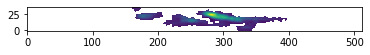

In [46]:
imshow(collapse1.value, origin='lower')

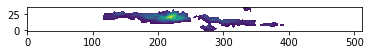

In [47]:
imshow(collapse2.value, origin='lower')

In [48]:
# Some leftover code from going over this with Adam
# Log file is located here: 
# /orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/imaging_results/ipython_log_2021-06-21.py

# subcube_regrid.with_mask(mask, tolerance=1000)
# subcube_regrid.with_mask(mask.include())
# mask.include()
# mask = (h2cscube > 5*u.mJy/u.beam).include().compute()
# subcube_regrid.with_mask(mask)
# #subcube_regrid.with_mask(mask).write('
# get_ipython().run_line_magic('history', '')
# subcube_regrid.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits')
# masked_subcube_regrid = subcube_regrid.with_mask(mask)
# masked_subcube_regrid.write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# masked_subcube_regrid
# masked_subcube_regrid.rechunk()
# masked_subcube_regrid.rechunk().write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)

# ch3cnK0 = SpectralCube.read('./thioformaldehyde/H2CS_303-202.fits')
# ch3cnK0
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg.with_mask(mask)
# ch3cnK0 = SpectralCube.read('CH3CN_8(0)-7(0).fits')
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# h2cscube
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg
# ch3cnK0_rg.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# #cube = SpectralCube.read('../imaging_results/source_ab_137_spw69_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dc_rg
# ch3cnK0_dc_rg._data
# mch3cnK0_dc_rg = ch3cnK0_dc_rg.with_mask(mask)
# with ProgressBar():
#     mch3cnK0_dc_rg.write('TEST.fits')

## 10. Export Masked Cubes
Now, we will repeat this for the rest of the CH3CN rungs. I will change the `0` index to `1` in the frequency list in the first cell and re-run all cells, then repeat for all rungs (exporting masked cubes and noise maps to `.fits` files). Once I feel comfortable doing that, I might make this into a more compartmentalized set of functions.

### Export noise map from template molecule and masked cubes for each rung
The masked cube cell needs to be run each time we go through a new rung. The flow of this notebook is currently not very linear, but I will try to fix it in the future. Channel widths can be calculated from the masked cubes.

In [49]:
# template_noise = mad_std_map_sclip
# template_noise.write('methyl_cyanide/template_noise.fits')

In [50]:
# ch3cn_7_masked = masked_cube_no_outliers
# ch3cn_7_masked.write('methyl_cyanide/ch3cn_7_masked.fits')

In [51]:
# This is an attempt to re-run the notebook for all rungs except index 0. It is untested.
# for ch3cn_freq in ch3cn_freqs[1:]:
    
#     # Convert cube spectral axes from frequency to velocity
#     ch3cncube = ch3cncube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
#                                              rest_value=ch3cn_freq*u.GHz).spectral_slab(-10*u.km/u.s, 
#                                                                                         80*u.km/u.s)
#     print(ch3cncube)
#     ch3cnsubcube = ch3cncube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)
    
#     # Do some quicklooks of the peak intensity to see what we expect to see
#     ch3cnsubcube.max(axis=0).quicklook()
    
#     # Spectral interpolation
#     ch3cnsubcube_common_beam = ch3cnsubcube.beams.common_beam()
#     ch3cnsubcube_b = ch3cnsubcube.convolve_to(ch3cnsubcube_common_beam)
#     ch3cnsubcube_b = ch3cnsubcube_b.with_spectral_unit(u.km/u.s)
#     velocity_res_2 = np.diff(ch3cnsubcube_b.spectral_axis)[0]
#     fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
#     spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)
#     vel_lo = np.max([h2cssubcube_b.spectral_axis.min().value, 
#                      ch3cnsubcube_b.spectral_axis.min().value])*u.km/u.s
#     vel_hi = np.min([h2cssubcube_b.spectral_axis.max().value, 
#                      ch3cnsubcube_b.spectral_axis.max().value])*u.km/u.s
#     h2cssubcube_bc = h2cssubcube_b.spectral_slab(vel_lo, vel_hi)
#     ch3cnsubcube_bc = ch3cnsubcube_b.spectral_slab(vel_lo, vel_hi)
#     ch3cnsubcube_bc_spec = ch3cnsubcube_bc.spectral_smooth(spectral_smoothing_kernel)
#     ch3cnsubcube_bc_spec_resample = ch3cnsubcube_bc_spec.spectral_interpolate(h2cssubcube_bc.spectral_axis)

#     # Spatial smoothing
#     ## Here we assume that the H2CS beam is larger, which might not always be right?
#     common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[h2cssubcube_bc.beam, 
#                                                                           ch3cnsubcube_bc_spec_resample.beam]))
#     ch3cnsubcube_bc_spec_resample_spat = ch3cnsubcube_bc_spec_resample.to(u.K).convolve_to(common_beam)
    
#     # Reprojection
#     ch3cnsubcube_bc_reproj = ch3cnsubcube_bc_spec_resample_spat.reproject(h2cssubcube_bc.header)
    
#     # Continuum subtraction
#     med1 = h2cssubcube_bc.median(axis=0)  
#     h2cssubcube_f = h2cssubcube_bc - med1
#     med2 = ch3cnsubcube_bc_reproj.median(axis=0)  
#     ch3cnsubcube_f_reproj = ch3cnsubcube_bc_reproj - med2
    
#     # More to do here...